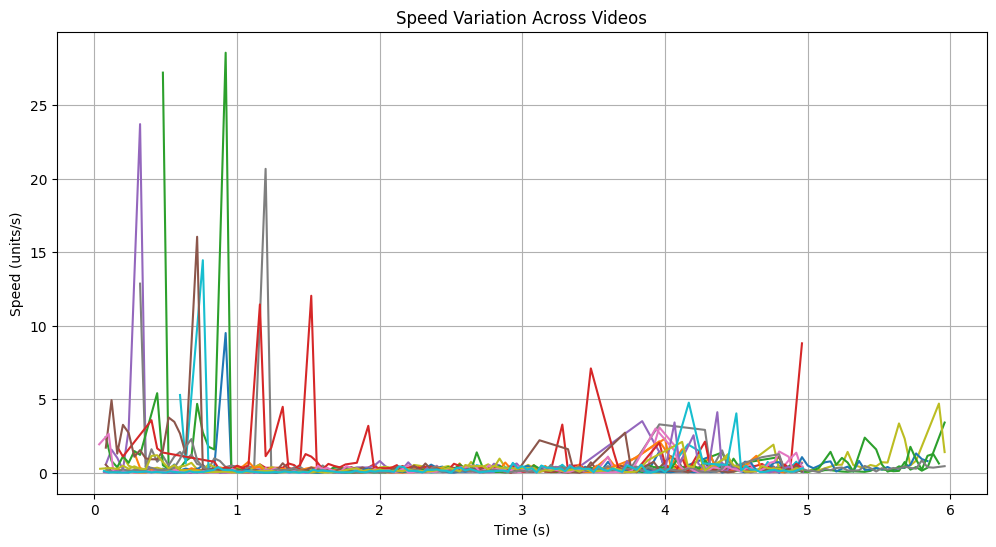

In [4]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import os

# Initialize Mediapipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

def process_video(video_path):
    """Process a single video to extract speed variation."""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_time = 1 / fps  # Time per frame

    positions = []  # Store landmark positions (e.g., hips center)
    timestamps = []  # Store corresponding timestamps

    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to RGB (Mediapipe requires RGB input)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process frame with Mediapipe Pose
        results = pose.process(rgb_frame)

        if results.pose_landmarks:
            # Extract key landmarks (e.g., hips)
            left_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
            right_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]

            # Compute center of hips
            center_hip_x = (left_hip.x + right_hip.x) / 2
            center_hip_y = (left_hip.y + right_hip.y) / 2

            # Store position and timestamp
            positions.append((center_hip_x, center_hip_y))
            timestamps.append(frame_index * frame_time)

        frame_index += 1

    cap.release()

    # Calculate speed
    speeds = []
    for i in range(1, len(positions)):
        dx = positions[i][0] - positions[i - 1][0]
        dy = positions[i][1] - positions[i - 1][1]
        displacement = np.sqrt(dx**2 + dy**2)
        speed = displacement / frame_time  # Speed in units/frame time
        speeds.append(speed)

    return timestamps[1:], speeds

def plot_speeds_from_folder(folder_path):
    """Process all videos in a folder and plot speed graphs together."""
    video_files = [f for f in os.listdir(folder_path) if f.endswith(('.mp4', '.avi', '.mov'))]
    plt.figure(figsize=(12, 6))

    for video_file in video_files:
        video_path = os.path.join(folder_path, video_file)
        timestamps, speeds = process_video(video_path)

        # Plot speed for the current video
        plt.plot(timestamps, speeds, label=os.path.basename(video_file))

    # Graph settings
    plt.xlabel("Time (s)")
    plt.ylabel("Speed (units/s)")
    plt.title("Speed Variation Across Videos")
    plt.grid()
    plt.show()

# Specify the folder containing the videos
folder_path = "vid"
plot_speeds_from_folder(folder_path)


C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


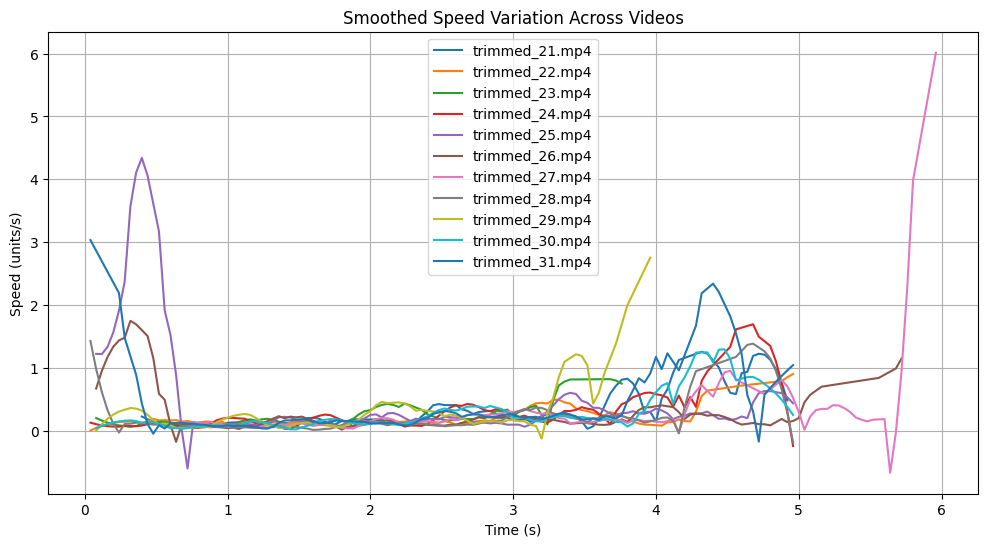

Feature matrix saved to features1.csv


In [12]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter, find_peaks
import pandas as pd

# Initialize Mediapipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

def process_video(video_path, smoothing=True):
    """Process a single video to extract speed variation."""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_time = 1 / fps  # Time per frame

    positions = []  # Store landmark positions (e.g., hips center)
    timestamps = []  # Store corresponding timestamps

    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to RGB (Mediapipe requires RGB input)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process frame with Mediapipe Pose
        results = pose.process(rgb_frame)

        if results.pose_landmarks:
            # Extract key landmarks (e.g., hips)
            left_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
            right_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]

            # Compute center of hips
            center_hip_x = (left_hip.x + right_hip.x) / 2
            center_hip_y = (left_hip.y + right_hip.y) / 2

            # Store position and timestamp
            positions.append((center_hip_x, center_hip_y))
            timestamps.append(frame_index * frame_time)

        frame_index += 1

    cap.release()

    if len(positions) < 2:
        return [], []  # Not enough data to calculate speed

    # Calculate speed
    speeds = []
    for i in range(1, len(positions)):
        dx = positions[i][0] - positions[i - 1][0]
        dy = positions[i][1] - positions[i - 1][1]
        displacement = np.sqrt(dx**2 + dy**2)
        speed = displacement / frame_time  # Speed in units/frame time
        speeds.append(speed)

    # Apply smoothing if requested and data is sufficient
    if smoothing and len(speeds) > 11:  # Window size for smoothing must be smaller than data length
        speeds = savgol_filter(speeds, window_length=11, polyorder=2)

    return timestamps[1:], speeds

def extract_features(timestamps, speeds):
    """Extract features from speed data."""
    if len(speeds) == 0:  # Check for empty speed data
        return {
            "mean_speed": 0,
            "max_speed": 0,
            "std_speed": 0,
            "mean_acceleration": 0,
            "max_acceleration": 0,
            "num_peaks": 0,
        }

    # Statistical features
    mean_speed = np.mean(speeds)
    max_speed = np.max(speeds)
    std_speed = np.std(speeds)

    # Acceleration features
    accelerations = np.diff(speeds) / (timestamps[1] - timestamps[0]) if len(timestamps) > 1 else []
    mean_acceleration = np.mean(accelerations) if len(accelerations) > 0 else 0
    max_acceleration = np.max(accelerations) if len(accelerations) > 0 else 0

    # Peaks
    peaks, _ = find_peaks(speeds, height=0.5)  # Peaks above a threshold
    num_peaks = len(peaks)

    return {
        "mean_speed": mean_speed,
        "max_speed": max_speed,
        "std_speed": std_speed,
        "mean_acceleration": mean_acceleration,
        "max_acceleration": max_acceleration,
        "num_peaks": num_peaks,
    }

def plot_smoothed_speeds_from_folder(folder_path):
    """Process all videos in a folder and plot smoothed speed graphs together."""
    video_files = [f for f in os.listdir(folder_path) if f.endswith(('.mp4', '.avi', '.mov'))]
    plt.figure(figsize=(12, 6))

    for video_file in video_files:
        video_path = os.path.join(folder_path, video_file)
        timestamps, speeds = process_video(video_path)

        if len(timestamps) > 0 and len(speeds) > 0:
            # Plot smoothed speeds
            plt.plot(timestamps, speeds, label=os.path.basename(video_file))

    # Graph settings
    plt.xlabel("Time (s)")
    plt.ylabel("Speed (units/s)")
    plt.title("Smoothed Speed Variation Across Videos")
    plt.legend()
    plt.grid()
    plt.show()

def generate_feature_matrix(folder_path, output_csv="features.csv"):
    """Process all videos, extract features, and save as a CSV for ML."""
    video_files = [f for f in os.listdir(folder_path) if f.endswith(('.mp4', '.avi', '.mov'))]
    feature_list = []

    for video_file in video_files:
        video_path = os.path.join(folder_path, video_file)
        timestamps, speeds = process_video(video_path)
        features = extract_features(timestamps, speeds)
        features["video"] = video_file
        feature_list.append(features)

    # Save to CSV
    feature_matrix = pd.DataFrame(feature_list)
    feature_matrix.to_csv(output_csv, index=False)
    print(f"Feature matrix saved to {output_csv}")

# Main script
if __name__ == "__main__":
    folder_path = "vdnt"  # Replace with your folder path
    output_csv = "features1.csv"

    # Plot all smoothed speed graphs
    plot_smoothed_speeds_from_folder(folder_path)

    # Generate and save feature matrix
    generate_feature_matrix(folder_path, output_csv=output_csv)


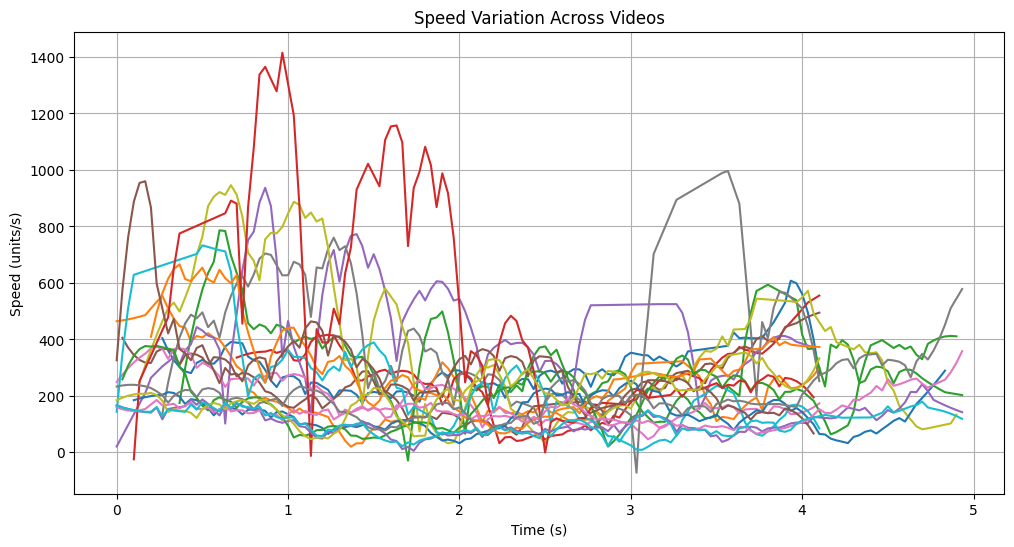

In [3]:
import cv2
import mediapipe as mp
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def calculate_speed_with_camera_compensation(video_path, fps=30):
    """
    Calculate speed of the athlete considering camera motion compensation.
    Args:
        video_path (str): Path to the video.
        fps (int): Frames per second of the video.
    Returns:
        list: Time values.
        list: Speed values.
    """
    cap = cv2.VideoCapture(video_path)
    frame_time = 1 / fps

    # Mediapipe Pose Setup
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()

    # Optical Flow Parameters
    lk_params = dict(winSize=(15, 15), maxLevel=2, 
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Variables to store motion data
    prev_landmarks = None
    prev_gray = None
    prev_points = None
    speeds = []
    times = []

    frame_index = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to grayscale and RGB
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect landmarks with Mediapipe
        results = pose.process(rgb_frame)
        if results.pose_landmarks:
            # Get the coordinates of the hips (or center of hips)
            left_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
            right_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
            athlete_position = np.array([
                (left_hip.x + right_hip.x) / 2,
                (left_hip.y + right_hip.y) / 2
            ])

            # Initialize optical flow tracking points (background)
            if prev_gray is None:
                prev_gray = gray_frame
                prev_landmarks = athlete_position
                prev_points = cv2.goodFeaturesToTrack(prev_gray, mask=None, maxCorners=100, 
                                                      qualityLevel=0.3, minDistance=7, blockSize=7)
                if prev_points is None:  # If no points are detected, skip frame
                    continue
                continue

            # Optical flow to estimate camera motion
            next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, gray_frame, prev_points, None, **lk_params)
            if next_points is None:  # Skip frame if no points are tracked
                prev_gray = gray_frame.copy()
                prev_points = cv2.goodFeaturesToTrack(prev_gray, mask=None, maxCorners=100, 
                                                      qualityLevel=0.3, minDistance=7, blockSize=7)
                continue

            good_prev = prev_points[status == 1]
            good_next = next_points[status == 1]

            if len(good_prev) == 0 or len(good_next) == 0:  # Ensure valid points exist
                prev_gray = gray_frame.copy()
                prev_points = cv2.goodFeaturesToTrack(prev_gray, mask=None, maxCorners=100, 
                                                      qualityLevel=0.3, minDistance=7, blockSize=7)
                continue

            # Estimate camera motion as the mean displacement of good points
            camera_motion = np.mean(good_next - good_prev, axis=0)

            # Athlete motion relative to the camera
            relative_motion = athlete_position - prev_landmarks - camera_motion
            displacement = np.linalg.norm(relative_motion)
            speed = displacement / frame_time

            # Save speed and time
            speeds.append(speed)
            times.append(frame_index * frame_time)

            # Update previous values
            prev_landmarks = athlete_position
            prev_gray = gray_frame.copy()
            prev_points = good_next.reshape(-1, 1, 2)

        frame_index += 1

    cap.release()
    return times, speeds



def process_videos_in_folder(folder_path, fps=30, smooth=True):
    """
    Process all videos in a folder and plot speed graphs.
    Args:
        folder_path (str): Path to the folder containing videos.
        fps (int): Frames per second of the videos.
        smooth (bool): Whether to apply smoothing to the speed graphs.
    """
    video_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.mp4', '.avi'))]
    all_speeds = []

    plt.figure(figsize=(12, 6))
    for video_path in video_files:
        # Calculate speed
        times, speeds = calculate_speed_with_camera_compensation(video_path, fps=fps)
        if smooth:
            speeds = savgol_filter(speeds, window_length=11, polyorder=2)  # Smoothing

        # Plot speed
        plt.plot(times, speeds, label=os.path.basename(video_path))
        all_speeds.append(speeds)

    # Finalize plot
    plt.title("Speed Variation Across Videos")
    plt.xlabel("Time (s)")
    plt.ylabel("Speed (units/s)")
    plt.grid()
    plt.show()

    return all_speeds


# Example Usage
folder_path = "vid"  # Replace with your folder path
fps = 30  # Adjust based on your video frame rate
all_speeds = process_videos_in_folder(folder_path, fps=fps, smooth=True)


Processing vid\trimmed_1.mp4
Processing vid\trimmed_10.mp4
Processing vid\trimmed_11.mp4
Processing vid\trimmed_12.mp4
Processing vid\trimmed_13.mp4
Processing vid\trimmed_14.mp4
Processing vid\trimmed_15.mp4
Processing vid\trimmed_16.mp4
Processing vid\trimmed_17.mp4
Processing vid\trimmed_18.mp4
Processing vid\trimmed_19.mp4
Processing vid\trimmed_2.mp4
Processing vid\trimmed_20.mp4
Processing vid\trimmed_21.mp4
Processing vid\trimmed_22.mp4
Processing vid\trimmed_23.mp4
Processing vid\trimmed_24.mp4
Processing vid\trimmed_25.mp4
Processing vid\trimmed_26.mp4
Processing vid\trimmed_27.mp4
Processing vid\trimmed_28.mp4
Processing vid\trimmed_29.mp4
Processing vid\trimmed_3.mp4
Processing vid\trimmed_30.mp4
Processing vid\trimmed_31.mp4
Processing vid\trimmed_4.mp4
Processing vid\trimmed_5.mp4
Processing vid\trimmed_6.mp4
Processing vid\trimmed_7.mp4
Processing vid\trimmed_8.mp4
Processing vid\trimmed_9.mp4


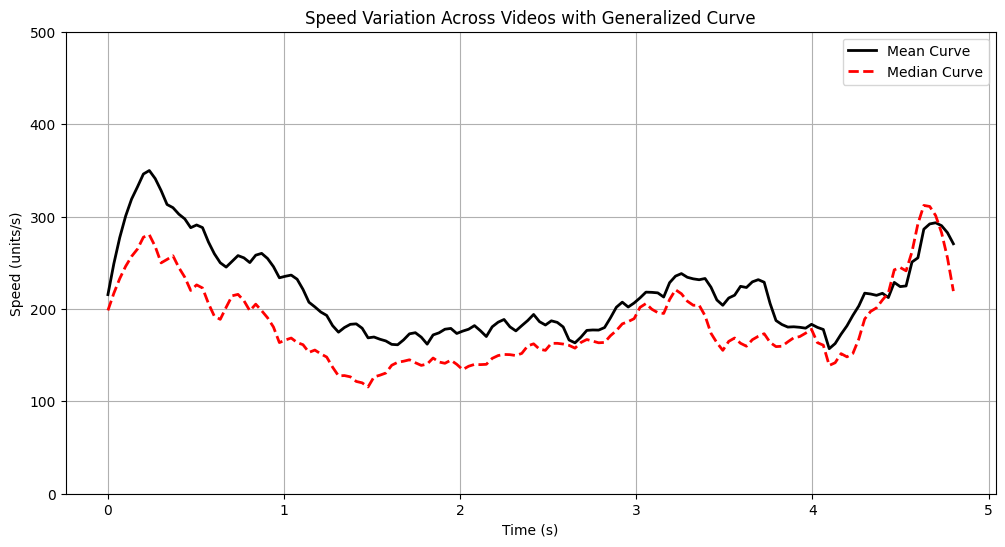

In [11]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import os


def calculate_speed_with_camera_compensation(video_path, fps=30):
    """
    Calculate speed of the athlete considering camera motion compensation.
    Args:
        video_path (str): Path to the video.
        fps (int): Frames per second of the video.
    Returns:
        list: Time values.
        list: Speed values.
    """
    cap = cv2.VideoCapture(video_path)
    frame_time = 1 / fps

    # Mediapipe Pose Setup
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()

    # Optical Flow Parameters
    lk_params = dict(winSize=(15, 15), maxLevel=2, 
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Variables to store motion data
    prev_landmarks = None
    prev_gray = None
    prev_points = None
    speeds = []
    times = []

    frame_index = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to grayscale and RGB
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect landmarks with Mediapipe
        results = pose.process(rgb_frame)
        if results.pose_landmarks:
            # Get the coordinates of the hips (or center of hips)
            left_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
            right_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
            athlete_position = np.array([
                (left_hip.x + right_hip.x) / 2,
                (left_hip.y + right_hip.y) / 2
            ])

            # Initialize optical flow tracking points (background)
            if prev_gray is None:
                prev_gray = gray_frame
                prev_landmarks = athlete_position
                prev_points = cv2.goodFeaturesToTrack(prev_gray, mask=None, maxCorners=100, 
                                                      qualityLevel=0.3, minDistance=7, blockSize=7)
                if prev_points is None:  # If no points are detected, skip frame
                    continue
                continue

            # Optical flow to estimate camera motion
            next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, gray_frame, prev_points, None, **lk_params)
            if next_points is None:  # Skip frame if no points are tracked
                prev_gray = gray_frame.copy()
                prev_points = cv2.goodFeaturesToTrack(prev_gray, mask=None, maxCorners=100, 
                                                      qualityLevel=0.3, minDistance=7, blockSize=7)
                continue

            good_prev = prev_points[status == 1]
            good_next = next_points[status == 1]

            if len(good_prev) == 0 or len(good_next) == 0:  # Ensure valid points exist
                prev_gray = gray_frame.copy()
                prev_points = cv2.goodFeaturesToTrack(prev_gray, mask=None, maxCorners=100, 
                                                      qualityLevel=0.3, minDistance=7, blockSize=7)
                continue

            # Estimate camera motion as the mean displacement of good points
            camera_motion = np.mean(good_next - good_prev, axis=0)

            # Athlete motion relative to the camera
            relative_motion = athlete_position - prev_landmarks - camera_motion
            displacement = np.linalg.norm(relative_motion)
            speed = displacement / frame_time

            # Save speed and time
            speeds.append(speed)
            times.append(frame_index * frame_time)

            # Update previous values
            prev_landmarks = athlete_position
            prev_gray = gray_frame.copy()
            prev_points = good_next.reshape(-1, 1, 2)

        frame_index += 1

    cap.release()
    return times, speeds
# Function to process videos in a folder
def process_videos_in_folder(folder_path, fps=30, smooth=True):
    all_speeds = []
    all_times = []
    
    # Collect video files from folder
    video_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".mp4")]

    # Process each video
    for video_path in video_files:
        print(f"Processing {video_path}")
        times, speeds = calculate_speed_with_camera_compensation(video_path, fps=fps)
        
        # Check if speeds and times have been correctly calculated
        if len(speeds) > 0 and len(times) > 0:
            all_speeds.append(speeds)
            all_times.append(times)
        else:
            print(f"Warning: Empty data for video {video_path}")

    return all_times, all_speeds

# Plot generalized curve with mean and median of all speeds
def plot_generalized_curve(all_speeds, all_times, smooth=True, clip_outliers=True, y_limit=None):
    if not all_speeds or not all_times:
        print("Error: No speed data found. Ensure that the videos are processed correctly.")
        return

    # Determine the maximum length of time for alignment
    max_length = max(len(t) for t in all_times)

    # Create an aligned array for speeds (fill shorter arrays with NaN)
    aligned_speeds = np.full((len(all_speeds), max_length), np.nan)
    for i, speeds in enumerate(all_speeds):
        aligned_speeds[i, :len(speeds)] = speeds

    # Clip outliers (optional)
    if clip_outliers:
        speeds_flat = aligned_speeds.flatten()
        speed_median = np.nanmedian(speeds_flat)
        speed_std = np.nanstd(speeds_flat)
        lower_bound = speed_median - 3 * speed_std
        upper_bound = speed_median + 3 * speed_std
        aligned_speeds = np.clip(aligned_speeds, lower_bound, upper_bound)

    # Compute the mean and median curves (ignoring NaN values)
    mean_curve = np.nanmean(aligned_speeds, axis=0)
    median_curve = np.nanmedian(aligned_speeds, axis=0)

    # Smooth the generalized curves if required
    if smooth:
        mean_curve = savgol_filter(mean_curve, window_length=11, polyorder=2, mode='interp')
        median_curve = savgol_filter(median_curve, window_length=11, polyorder=2, mode='interp')

    # Time axis for the generalized curve
    generalized_time = np.linspace(0, max_length / fps, max_length)

    # Plot individual curves
    plt.figure(figsize=(12, 6))

    # Plot generalized curves
    plt.plot(generalized_time, mean_curve, color='black', linewidth=2, label='Mean Curve')
    plt.plot(generalized_time, median_curve, color='red', linewidth=2, linestyle='--', label='Median Curve')

    # Add labels and legend
    plt.title("Speed Variation Across Videos with Generalized Curve")
    plt.xlabel("Time (s)")
    plt.ylabel("Speed (units/s)")
    plt.legend()
    plt.grid()

    # Adjust the y-axis limits if provided
    if y_limit is not None:
        plt.ylim(0, y_limit)

    plt.show()

# Main execution
folder_path = "vid"  # Replace with your folder path
fps = 30  # Adjust based on your video frame rate
all_times, all_speeds = process_videos_in_folder(folder_path, fps=fps, smooth=True)

# Adjusting the maximum speed for better visualization
max_speed_limit = 500  # Set an upper limit for the speed axis to clip extreme values
plot_generalized_curve(all_speeds, all_times, smooth=True, clip_outliers=True, y_limit=max_speed_limit)


In [13]:
from scipy.signal import find_peaks
import pandas as pd

# Function to calculate speed and acceleration from the video
def calculate_speed_and_acceleration(video_path, fps=30):
    times, speeds = calculate_speed_with_camera_compensation(video_path, fps=fps)  # Using the previous method
    if len(speeds) == 0:
        return None

    # Calculate acceleration (change in speed between consecutive frames)
    acceleration = np.diff(speeds) * fps  # Assuming 'speeds' is in units per frame, multiply by fps to get acceleration

    # Calculate statistics
    mean_speed = np.mean(speeds)
    max_speed = np.max(speeds)
    std_speed = np.std(speeds)

    mean_acceleration = np.mean(acceleration) if len(acceleration) > 0 else 0
    max_acceleration = np.max(acceleration) if len(acceleration) > 0 else 0

    # Detect peaks (local maxima)
    peaks, _ = find_peaks(speeds)
    num_peaks = len(peaks)

    return {
        "mean_speed": mean_speed,
        "max_speed": max_speed,
        "std_speed": std_speed,
        "mean_acceleration": mean_acceleration,
        "max_acceleration": max_acceleration,
        "num_peaks": num_peaks,
        "video_name": os.path.basename(video_path)
    }

# Process all videos in a folder and save statistics to CSV
def process_videos_in_folder_and_save_stats(folder_path, fps=30, output_csv="video_stats.csv"):
    video_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".mp4")]
    
    # List to hold the statistics for all videos
    stats_list = []
    
    for video_path in video_files:
        print(f"Processing {video_path}")
        video_stats = calculate_speed_and_acceleration(video_path, fps=fps)
        if video_stats:
            stats_list.append(video_stats)
    
    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(stats_list)
    
    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"Statistics saved to {output_csv}")

# Main execution
folder_path = "vid"  # Replace with your folder path
fps = 30  # Adjust based on your video frame rate
output_csv = "video_stats.csv"  # Output CSV file path

# Process and save statistics
process_videos_in_folder_and_save_stats(folder_path, fps=fps, output_csv=output_csv)


Processing vid\trimmed_1.mp4
Processing vid\trimmed_10.mp4
Processing vid\trimmed_11.mp4
Processing vid\trimmed_12.mp4
Processing vid\trimmed_13.mp4
Processing vid\trimmed_14.mp4
Processing vid\trimmed_15.mp4
Processing vid\trimmed_16.mp4
Processing vid\trimmed_17.mp4
Processing vid\trimmed_18.mp4
Processing vid\trimmed_19.mp4
Processing vid\trimmed_2.mp4
Processing vid\trimmed_20.mp4
Processing vid\trimmed_21.mp4
Processing vid\trimmed_22.mp4
Processing vid\trimmed_23.mp4
Processing vid\trimmed_24.mp4
Processing vid\trimmed_25.mp4
Processing vid\trimmed_26.mp4
Processing vid\trimmed_27.mp4
Processing vid\trimmed_28.mp4
Processing vid\trimmed_29.mp4
Processing vid\trimmed_3.mp4
Processing vid\trimmed_30.mp4
Processing vid\trimmed_31.mp4
Processing vid\trimmed_4.mp4
Processing vid\trimmed_5.mp4
Processing vid\trimmed_6.mp4
Processing vid\trimmed_7.mp4
Processing vid\trimmed_8.mp4
Processing vid\trimmed_9.mp4
Statistics saved to video_stats.csv
